In [ ]:
%pip install evidently

In [44]:
import requests
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnQuantileMetric
from datetime import datetime

from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric

from joblib import load, dump

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from evidently.metric_preset import DataDriftPreset, DataQualityPreset
from evidently.ui.workspace import Workspace
from evidently.ui.dashboards import DashboardPanelCounter, DashboardPanelPlot, CounterAgg, PanelValue, PlotType, ReportFilter
from evidently.renderers.html_widgets import WidgetSize

# Q1. Prepare the dataset

In [5]:
# Download the March 2024 Green Taxi data
url = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-03.parquet"
save_path = r"C:\Users\User\mlops-zoomcamp\HW_5\green_tripdata_2024-03.parquet"

print("Downloading March 2024 Green Taxi data...")
resp = requests.get(url, stream=True)
with open(save_path, "wb") as handle:
    for data in tqdm(resp.iter_content(), desc="green_tripdata_2024-03.parquet", total=int(resp.headers["Content-Length"])):
        handle.write(data)

# Load the dataset
march_data = pd.read_parquet(save_path)
march_data.head()

green_tripdata_2024-03.parquet: 100%|██████████| 1372372/1372372 [00:41<00:00, 32797.44it/s]


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2024-03-01 00:10:52,2024-03-01 00:26:12,N,1.0,129,226,1.0,1.72,12.8,1.0,0.5,3.06,0.0,NaN,1.0,18.36,1.0,1.0,0.00
1,2,2024-03-01 00:22:21,2024-03-01 00:35:15,N,1.0,130,218,1.0,3.25,17.7,1.0,0.5,0.00,0.0,NaN,1.0,20.20,2.0,1.0,0.00
2,2,2024-03-01 00:45:27,2024-03-01 01:04:32,N,1.0,255,107,2.0,4.58,23.3,1.0,0.5,3.50,0.0,NaN,1.0,32.05,1.0,1.0,2.75
3,1,2024-03-01 00:02:00,2024-03-01 00:23:45,N,1.0,181,71,1.0,0.00,22.5,0.0,1.5,0.00,0.0,NaN,1.0,24.00,1.0,1.0,0.00
4,2,2024-03-01 00:16:45,2024-03-01 00:23:25,N,1.0,95,135,1.0,1.15,8.6,1.0,0.5,1.00,0.0,NaN,1.0,12.10,1.0,1.0,0.00


In [6]:
# Print the shape of the dataset
print("Shape of the dataset:", march_data.shape)
print("Number of rows:", march_data.shape[0])

Shape of the dataset: (57457, 20)
Number of rows: 57457


# Q2. Metric

The metric we can choose is "ColumnCorrelationsMetric" to monitor correlations between numerical features and the target variable.

# Q3. Monitoring

<Axes: >

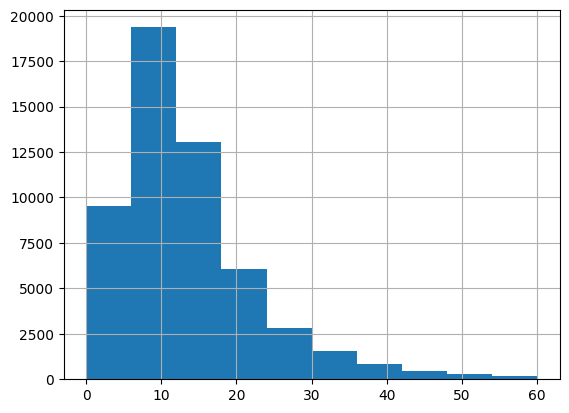

In [15]:
# Preprocess the data
march_data["duration_min"] = (march_data.lpep_dropoff_datetime - march_data.lpep_pickup_datetime).apply(lambda td: float(td.total_seconds()) / 60)

#  out outliers
march_data = march_data[(march_data.duration_min >= 0) & (march_data.duration_min <= 60)]
march_data = march_data[(march_data.passenger_count > 0) & (march_data.passenger_count <= 8)]

march_data.duration_min.hist()

In [18]:
# Create target and feature sets
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

# Split data into train and validation sets
train_data = march_data[:30000]
val_data = march_data[30000:]

# Train a simple model
model = LinearRegression()
model.fit(train_data[num_features + cat_features], train_data[target])

# Make predictions
train_preds = model.predict(train_data[num_features + cat_features])
train_data['prediction'] = train_preds
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds

In [19]:
# Dump model and reference data
with open(r'C:\Users\User\mlops-zoomcamp\HW_5\models\lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)
val_data.to_parquet(r'C:\Users\User\mlops-zoomcamp\HW_5\reference.parquet')

In [31]:
# Evidently ColumnMapping and Report setup
column_mapping = ColumnMapping(
    target=None,
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features
)

In [40]:
# Ensure datetime column is in the correct format
march_data['lpep_pickup_datetime'] = pd.to_datetime(march_data['lpep_pickup_datetime'])
march_data['day'] = march_data['lpep_pickup_datetime'].dt.date

# Filter data to include only dates within March 2024
start_date = pd.to_datetime('2024-03-01').date()
end_date = pd.to_datetime('2024-03-31').date()
march_data = march_data[(march_data['day'] >= start_date) & (march_data['day'] <= end_date)]

# Create an empty list to store quantile values
quantile_values = []

# Get unique days within March 2024
unique_days = march_data['day'].unique()

# Run Evidently reports for each unique day and store the quantile values
for day in unique_days:
    day_data = march_data[march_data['day'] == day]
    report = Report(metrics=[
        ColumnQuantileMetric(column_name='fare_amount', quantile=0.5)
    ])
    report.run(reference_data=march_data, current_data=day_data, column_mapping=column_mapping)
    quantile_result = report.as_dict()['metrics'][0]['result']['current']['value']
    quantile_values.append(quantile_result)

# Find the maximum quantile value
max_quantile_value = max(quantile_values)
print("Maximum value of the 0.5 quantile for fare_amount during March 2024:", max_quantile_value)

Maximum value of the 0.5 quantile for fare_amount during March 2024: 14.2


# Q4. Dashboard

To save the dashboard configuration file we use in the project_folder/config (05-monitoring/config) directory. In our case this is HW_5/config

In [42]:
# Initialize workspace
ws = Workspace("workspace")
project = ws.create_project("NYC Taxi Data Quality Project")
project.description = "My project description"
project.save()

# Add metrics to the report
regular_report = Report(
    metrics=[
        DataQualityPreset()
    ],
    timestamp=datetime(2024, 3, 1)
)

# Run report on current data
regular_report.run(reference_data=None,
                  current_data=march_data,
                  column_mapping=column_mapping)

# Add report to the project
ws.add_report(project.id, regular_report)

# Configure the dashboard
project.dashboard.add_panel(
    DashboardPanelCounter(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        agg=CounterAgg.NONE,
        title="NYC Taxi Data Dashboard"
    )
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Inference Count",
        values=[
            PanelValue(
                metric_id="DatasetSummaryMetric",
                field_path="current.number_of_rows",
                legend="count"
            ),
        ],
        plot_type=PlotType.BAR,
        size=WidgetSize.HALF,
    ),
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Number of Missing Values",
        values=[
            PanelValue(
                metric_id="DatasetSummaryMetric",
                field_path="current.number_of_missing_values",
                legend="count"
            ),
        ],
        plot_type=PlotType.LINE,
        size=WidgetSize.HALF,
    ),
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Fare Amount Median (0.5 Quantile)",
        values=[
            PanelValue(
                metric_id="ColumnQuantileMetric",
                field_path="current.value",
                legend="median"
            ),
        ],
        plot_type=PlotType.LINE,
        size=WidgetSize.HALF,
    ),
)

project.save()

Project(id=UUID('d965b7bb-1afa-4806-8d65-be3af8ada85d'), name='NYC Taxi Data Quality Project', description='My project description', dashboard=DashboardConfig(name='NYC Taxi Data Quality Project', panels=[DashboardPanelCounter(type='evidently.ui.dashboards.reports.DashboardPanelCounter', id=UUID('f9d55af2-96e1-4dcd-8db5-903e421d0207'), title='NYC Taxi Data Dashboard', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.FULL: 2>, agg=<CounterAgg.NONE: 'none'>, value=None, text=None), DashboardPanelPlot(type='evidently.ui.dashboards.reports.DashboardPanelPlot', id=UUID('095ffda4-8e27-4846-8cd0-e2fe37ee41a3'), title='Inference Count', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.HALF: 1>, values=[PanelValue(field_path='current.number_of_rows', metric_id='DatasetSummaryMetric', metric_fingerprint=None, metric_args={}, legend='count')], plot_type=<PlotType.BAR: 'bar'>), DashboardPanelPlot(

In [48]:
# Extract the configuration details manually
dashboard_config = {
    'project_id': str(project.id),
    'project_name': project.name,
    'project_description': project.description,
    'dashboard': {
        'panels': [
            {
                'type': 'counter',
                'title': 'NYC Taxi Data Dashboard',
                'agg': 'none',
                'size': 'full'
            },
            {
                'type': 'plot',
                'title': 'Inference Count',
                'metric_id': 'DatasetSummaryMetric',
                'field_path': 'current.number_of_rows',
                'legend': 'count',
                'plot_type': 'bar',
                'size': 'half'
            },
            {
                'type': 'plot',
                'title': 'Number of Missing Values',
                'metric_id': 'DatasetSummaryMetric',
                'field_path': 'current.number_of_missing_values',
                'legend': 'count',
                'plot_type': 'line',
                'size': 'half'
            },
            {
                'type': 'plot',
                'title': 'Fare Amount Median (0.5 Quantile)',
                'metric_id': 'ColumnQuantileMetric',
                'field_path': 'current.value',
                'legend': 'median',
                'plot_type': 'line',
                'size': 'half'
            }
        ]
    }
}

In [51]:
# Save the dashboard configuration to a JSON file
config_path = "C:\\Users\\User\\mlops-zoomcamp\\HW_5\\config\\dashboard_config.json"

with open(config_path, "w") as f:
    json.dump(dashboard_config, f, indent=4)

print(f"Dashboard configuration saved to {config_path}")

Dashboard configuration saved to C:\Users\User\mlops-zoomcamp\HW_5\config\dashboard_config.json
